In [3]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation,DataService # type: ignore
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import pandas_ta as ta

In [4]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [5]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# 定义因子！

In [ ]:
def smart_money_sumd(df, window=60):
    """
    融合主力资金流向（已添加中间部分左右翻转和积分操作）
    1. 计算原始因子值
    2. 识别中间分组(4-11组)对应的因子值范围
    3. 对中间部分进行左右翻转（镜像翻转）
    4. 应用积分操作增强单调性
    """
    close = df['close'] 
    price_diff = close.diff()
    
    taker_ratio = df['taker_buy_volume'] / df['volume'].replace(0, 1e-12)
    
    # 主力资金方向加权的价格变动
    gain = (price_diff * taker_ratio).where(price_diff > 0, 0)
    loss = (-price_diff * (1 - taker_ratio)).where(price_diff < 0, 0)
    
    sum_gain = gain.rolling(window).sum()
    sum_loss = loss.rolling(window).sum()
    
    # 加入市场情绪调整
    market_strength = (df['high'] - df['low']).rolling(window).mean() + 1e-12
    factor_orig = (sum_gain - sum_loss) / market_strength
    
    # 识别中间分组对应的因子值范围（4-11组）
    low_bound = factor_orig.quantile(0.1)  # 约第4组
    high_bound = factor_orig.quantile(0.5)  # 约第11组
    
    # 创建因子副本并进行中间部分左右翻转（镜像翻转）
    factor_flipped = factor_orig.copy()
    mask = (factor_orig >= low_bound) & (factor_orig <= high_bound)
    
    # 左右翻转：将中间部分的值映射到镜像位置
    # 公式：flipped_value = (high_bound + low_bound) - original_value
    factor_flipped.loc[mask] = (high_bound + low_bound) - factor_flipped.loc[mask]
    
    # 应用积分操作（累积和）增强单调性
    factor_integrated = factor_flipped.cumsum()
    
    # # 标准化处理以保持因子稳定性
    # rolling_mean = factor_integrated.rolling(window*10).mean()
    # rolling_std = factor_integrated.rolling(window*10).std().replace(0, 1e-12)
    # factor_final = (factor_integrated - rolling_mean) / rolling_std
    
    return factor_flipped

# 因子测试

In [83]:
evaluator.set_factor(
    factor_func=smart_money_sumd,
    factor_name='smart_money_sumd'
)


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): 0.024621
   Rank_IC (Spearman): -0.012102
📊 信息比率:
   IR: 0.927875
   有效分组数: 10
📊 因子分布:
📋 数据概况:
   数据长度: 127963
   因子列: smart_money_sumd
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------
📊 显示分组分析图...


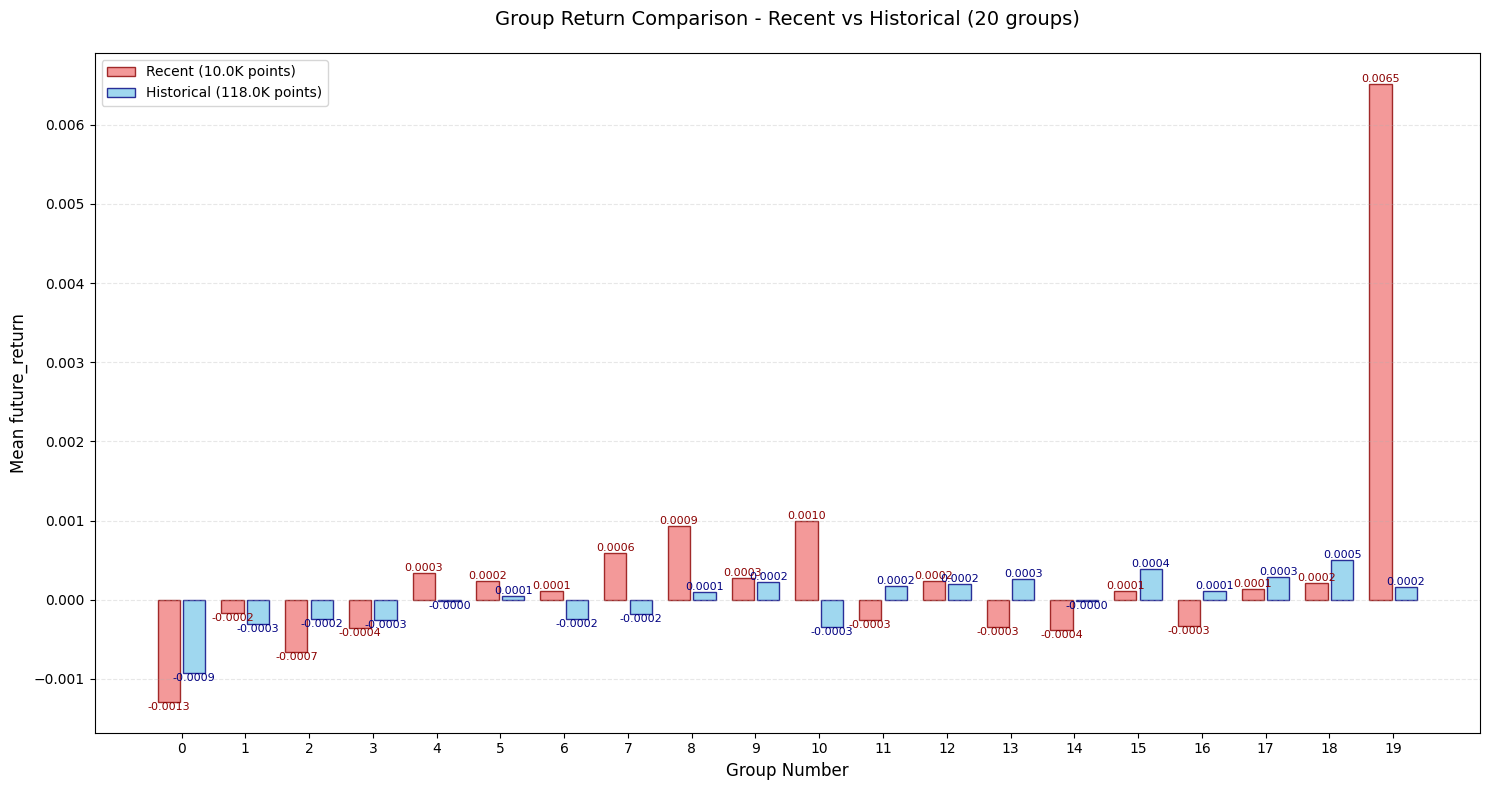

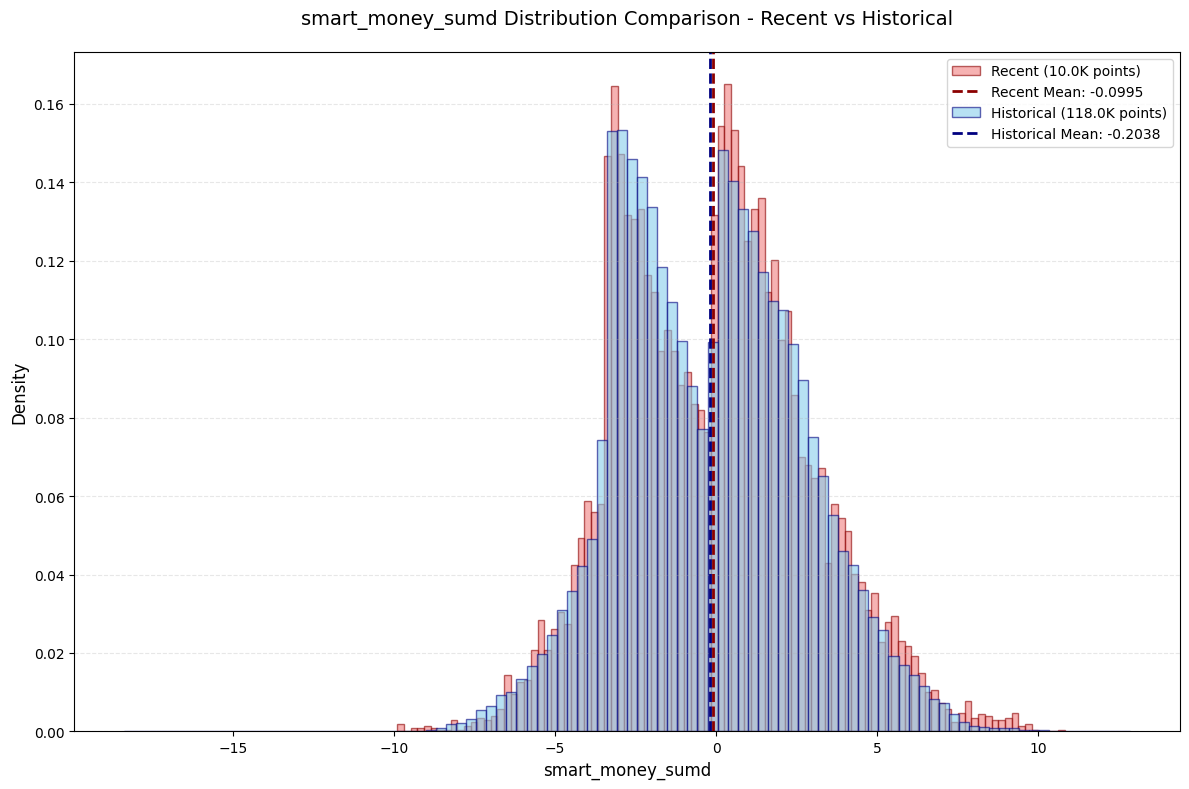

📈 显示因子分布图...
✅ 已显示 2 个图片
----------------------------------------


In [84]:
result=evaluator.run_full_evaluation(run_stationarity_test=False)

In [85]:
print(result)

{'correlation_analysis': {'IC': 0.02462144853894602, 'Rank_IC': -0.012101651451464742}, 'information_ratio': {'IR': 0.9278753129825448, 'group_correlations': [0.007958534150057575, 0.0039158000326068535, 0.0020327961678771084, 0.005488731797339411, 0.0038230349544624296, 0.01700542349491013, -0.007548869387762842, 0.01733809698679645, 0.003946032869082879, 0.018952342839654312], 'n_groups': 10}, 'group_analysis': {'group_stats':        val_min  val_max  val_mean  return_mean  return_std  count
group                                                            
0     -18.3721  -4.4996   -5.6482      -0.0009      0.0169   6399
1      -4.4995  -3.4470   -3.9279      -0.0003      0.0127   6398
2      -3.4470  -3.1237   -3.2854      -0.0003      0.0108   6398
3      -3.1237  -2.7950   -2.9596      -0.0003      0.0113   6398
4      -2.7949  -2.4509   -2.6232       0.0000      0.0110   6398
5      -2.4508  -2.0908   -2.2731       0.0000      0.0109   6398
6      -2.0907  -1.7020   -1.9011      